In [1]:
import os
import glob

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.metrics import confusion_matrix
import random
from matplotlib.ticker import MaxNLocator

# Seed
seed = 2022
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab\ Notebooks/3_Split'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/3_Split


In [3]:
# %ls

In [4]:
label_dict = {
    "Non-stroke": 0,
    "ICH": 1,
    "Ischemic": 1,
}

In [5]:
class EGGLSTMDataset(Dataset):
    
    def __init__(self, data_path, label_dict, transform=None):
        self.files = sorted(glob.glob(os.path.join(data_path, "*.txt")))
        self.n = len(self.files)
        self.label_dict = label_dict
        self.transform = transform
        
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        with open(self.files[idx]) as f:
            data = f.readlines()
        x = np.array([np.array([float(v.strip()) for v in d.split(',')[:-1]])[None, :] for d in data[0:4]])
        x = np.concatenate(x)
        # std_ = np.std(x, axis=1, keepdims=True)
        # x = x / np.where( std_ > 1.0 , std_, 1.0)
        y = label_dict[data[4]]
        x = torch.Tensor(x)
        y = torch.Tensor([y])
        if self.transform:
            x = self.transform(x)
        return x, y


In [6]:
# size=(4, 500)
# transform = T.Compose([
#     T.RandomCrop(size)
# ])
ds_train = EGGLSTMDataset("Train_oversample_rnn_new", label_dict)
print("ds_train", len(ds_train))
ds_val = EGGLSTMDataset("Val_rnn", label_dict)
labels = [int(y) for _, y in ds_val]
print("ds_val", len(ds_val))

x, y = ds_train[2851]
print(x.shape)
print(y)

ds_train 3327
ds_val 241
torch.Size([4, 1000])
tensor([1.])


In [7]:
# fig = plt.figure(figsize=(20, 10))

# for i in range(4):
#     plt.subplot(4, 1, i + 1)
#     plt.plot(x[i, :])

## Netwok

In [8]:
model = nn.LSTM(input_size=4, hidden_size=128, num_layers=2, bidirectional=False, proj_size=2)
model

LSTM(4, 128, proj_size=2, num_layers=2)

In [9]:
## 如果要load特定model 請改back up之model名
# model.load_state_dict(torch.load('backup_rnn_base_5E-4_000600.pth'))

In [10]:
outputs, _ = model(x.transpose(0, 1).unsqueeze(1))
outputs.shape

torch.Size([1000, 1, 2])

In [11]:
device = torch.device("cuda:0")
model = model.to(device)

## Data Loader

In [12]:
dl_train = DataLoader(ds_train, shuffle=True, batch_size=40, drop_last=True)
dl_val = DataLoader(ds_val, shuffle=False, batch_size=40, drop_last=False)

## Train

In [13]:
def val(model, dl_val, device, labels):
  model.eval()
  predictions = []
  with torch.no_grad():
      for (x, y) in dl_val:
          x = x.to(device)
          y = y.to(device)
          outputs, _ = model(x.transpose(0, 2).transpose(1, 2))
          predictions.append(outputs[-1, :, :])
  
  predictions = np.concatenate([p.cpu().numpy() for p in predictions], axis=0)
  preds = np.argmax(predictions, axis=1)
  cm_norm = confusion_matrix(labels, preds, normalize="true")
  cm_pred = confusion_matrix(labels, preds)
  return cm_norm, cm_pred, preds, labels
  

In [ ]:
print_every = 10
backup_every = 100

n_epoch = 500
lr = 0.0005
model_name = 'backup_rnn_base_5E-4+500'
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

loss_log = []
c0_log = []
c1_log = []
c2_log = []
seen = 0

for i in tqdm(range(n_epoch)):
    j = 0
    for (x, y) in dl_train:
        model.train()
        # print("x", x.size(), "y", y.size())
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs, _ = model(x.transpose(0, 2).transpose(1, 2))
        # print("outputs", outputs.size())
        loss = loss_fn(outputs[-1, :, :], y[:, 0].long())
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            j += loss
            seen = seen + x.size(0)
    j /= len(dl_train)
    
    if (i+1) % print_every == 0:
        print('epoch: ', i, 'cost: ', j.item())
        cm = val(model, dl_val, device, labels)[0]
        # print(cm[0][0], cm[1][1], cm[2][2], acc)
        c0_log.append(float(cm[0][0]))
        c1_log.append(float(cm[1][1]))
        # c2_log.append(float(cm[2][2]))
    if (i+1) % backup_every == 0:
      torch.save(model.state_dict(), "{}_{:06d}.pth".format(model_name, n_epoch))   
    loss_log.append(j)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch:  9 cost:  0.6042577624320984
epoch:  19 cost:  0.5539899468421936
epoch:  29 cost:  0.504216730594635
epoch:  39 cost:  0.46363911032676697
epoch:  49 cost:  0.425836443901062
epoch:  59 cost:  0.39819827675819397
epoch:  69 cost:  0.37667128443717957
epoch:  79 cost:  0.3489590585231781
epoch:  89 cost:  0.33156806230545044
epoch:  99 cost:  0.3152056634426117
epoch:  109 cost:  0.29447394609451294
epoch:  119 cost:  0.2829977869987488
epoch:  129 cost:  0.3626825213432312
epoch:  139 cost:  0.27927398681640625
epoch:  149 cost:  0.2622825503349304
epoch:  159 cost:  0.25039201974868774
epoch:  169 cost:  0.2541627585887909
epoch:  179 cost:  0.20835772156715393
epoch:  189 cost:  0.19850951433181763
epoch:  199 cost:  0.17366907000541687
epoch:  209 cost:  0.18752329051494598
epoch:  219 cost:  0.16151483356952667
epoch:  229 cost:  0.20083612203598022
epoch:  239 cost:  0.14160378277301788
epoch:  249 cost:  0.13373279571533203
epoch:  259 cost:  0.12328418344259262
epoch:  2

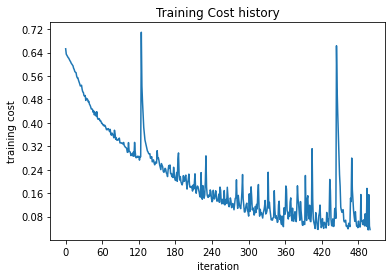

In [ ]:
# plot the cost history
plt.plot([loss_log[i].item() for i in range(len(loss_log))])
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('iteration')
plt.ylabel('training cost')
plt.title('Training Cost history')
plt.show()

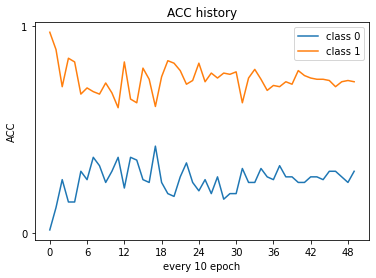

In [ ]:
# plot the cm
plt.plot(c0_log, label='class 0')
plt.plot(c1_log, label='class 1')
# plt.plot(c2_log, label='class 2')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('every ' + str(print_every) +' epoch')
plt.ylabel('ACC')
plt.title('ACC history')
plt.legend()
plt.show()

In [ ]:
# model.eval()

# predictions = []
# with torch.no_grad():
#     for (x, y) in tqdm(dl_val):
#         x = x.to(device)
#         y = y.to(device)
#         outputs, _ = model(x.transpose(0, 2).transpose(1, 2))
#         predictions.append(outputs[-1, :, :])

In [ ]:
# predictions = np.concatenate([p.cpu().numpy() for p in predictions], axis=0)
# print("predictions", predictions.shape)

In [ ]:
# labels = [int(y) for _, y in ds_val]
# preds = np.argmax(predictions, axis=1)
# cm = confusion_matrix(labels, preds, normalize="true")
# cm

In [ ]:
# acc = np.sum(labels == preds) / len(labels)
# print('Acc: ', acc)

In [ ]:
cm_norm, cm_pred, pred, labels = val(model, dl_val, device, labels)

In [ ]:
print(cm_norm)

[[0.2972973  0.7027027 ]
 [0.26946108 0.73053892]]


In [ ]:
print(cm_pred)

[[ 22  52]
 [ 45 122]]


In [ ]:
print('Acc: ', np.sum(labels == pred) / len(labels))

Acc:  0.5975103734439834


In [ ]:
# pred.dtype()

In [ ]:
pred_df = pd.DataFrame(
    {'pred': pred.tolist(),
     'labels' : labels})
pred_df

,pred,labels
0,1,1
1,0,1
2,1,1
3,0,1
4,0,1
...,...,...
236,1,1
237,1,1
238,0,1
239,1,1


In [ ]:
pred_df.to_csv('{}.csv'.format(model_name))